# Notícias G1 - 9. Classificação com Redes Neurais Performando

Será feita a classificação das notícias de categoria desconhecida com base no modelo treinado a partir de um modelo de rede neural e da massa de dados com categoria conhecida. 

Vamos fazer um algoritmo mais complexo que testa várias configurações da rede neural e compara os resultados obtidos a fim de selecionar, ao final, a melhor configuração.

## Imports:

Importes de bibliotecas usadas com frequência no código.

In [340]:
import pandas as pd
import numpy as np

## Recuperando Dados Gravados:

Recuperando dados gravados após cálculo de TF-IDF, criação de matrizes esparças e aplicação do One Hot Encoding.

In [341]:
df_tfidf_classificar = pd.read_csv("noticias_g1_tfidf_massa_classificar.csv")
df_tfidf_treino = pd.read_csv("noticias_g1_tfidf_massa_treino.csv")
df_tfidf_teste = pd.read_csv("noticias_g1_tfidf_massa_teste.csv")
df_cat_treino = pd.read_csv("noticias_g1_categorias_treino.csv")
df_cat_teste = pd.read_csv("noticias_g1_categorias_teste.csv")
df_one_hot_encoder = pd.read_csv('noticias_g1_one_hot_encoder.csv')

print(df_tfidf_classificar.shape, df_tfidf_treino.shape, 
      df_cat_treino.shape, df_tfidf_teste.shape, 
      df_cat_teste.shape, df_one_hot_encoder.shape)

(2111, 2494) (1206, 2494) (1206, 1) (517, 2494) (517, 1) (1206, 6)


## Criando Matrizes Esparsas:

Transformando os DataFrames em matrizes esparças para utilizar na classificação com rede neural.

In [342]:
from scipy.sparse import coo_matrix, vstack

sm_classificar = coo_matrix(df_tfidf_classificar)
sm_treino = coo_matrix(df_tfidf_treino)
sm_teste = coo_matrix(df_tfidf_teste)
sm_cat_treino = np.array(df_cat_treino)
sm_cat_teste = np.array(df_cat_teste)
sm_one_hot_encoder = np.array(df_one_hot_encoder)

print(sm_classificar.shape, sm_treino.shape, sm_cat_treino.shape,
      sm_teste.shape, sm_cat_teste.shape, sm_one_hot_encoder.shape)

(2111, 2494) (1206, 2494) (1206, 1) (517, 2494) (517, 1) (1206, 6)


## Tratando Desbalanceamento das Classes:

Como as classes estão muito desbalanceadas faremos o tratamento desse problema por meio do ajuste dos pesos para cada categoria. Isso será feito usando o sklearn.

In [343]:
from sklearn.utils import class_weight

y_integers = np.argmax(sm_one_hot_encoder, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 25.125,
 1: 0.43412526997840173,
 2: 7.178571428571429,
 3: 0.5726495726495726,
 4: 0.8854625550660793,
 5: 1.558139534883721}

### Definindo Classe Reutilizável para Classificação Multiclasse:

A classe abaixo possui propriedades que configuraram a construção e o processamento da rede neural. Ela também quebra o código em tarefas pequenas para tornar mais claras e legíveis as etapas do treinamento e busca da melhor configuração para a rede a fim de obter o melhor resultado.

A busca pela melhor configuração é feita tomando por base a figura de mérito e a verificação de ganho mínimo a cada ciclo de treinamento e teste.

In [370]:
#!pip install keras
#!pip install tensorflow

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import activations as keras_activations
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from collections import Counter, OrderedDict
import tensorflow

class MultiClassClassification:
    
    def __init__(
        self, X_train, X_test, y_train, y_test, 
        classes, class_weights, 
        qtt_layers = 3, min_neurons=1, max_neurons = 10, 
        epochs = 100, batch_size = 10, 
        random_seed = 33, min_improvement = 0.1,
        min_gain_increase_neurons = 3,
        patience_for_early_stop = None,
        patience_to_increase_neurons = 4,
        cut_for_unknown = 0.005,
        units=None, initializers = ['uniform'],
        ignore_early_stops = False,
        activation_function = keras_activations.relu,
        activations = None,
        optimizer = 'adam', loss = 'mse', #'binary_crossentropy'
        metrics = [] # 'accuracy', 'Precision', 'acc', 'crossentropy', 'ce'
    ):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.classes = classes
        self.class_weights = class_weights
        self.qtt_layers = qtt_layers
        self.min_neurons = min_neurons
        self.max_neurons = max_neurons
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_seed = random_seed
        self.cut_for_unknown = cut_for_unknown
        self.min_improvement = min_improvement
        self.min_gain_increase_neurons = min_gain_increase_neurons
        self.patience_for_early_stop = patience_for_early_stop
        self.patience_to_increase_neurons = patience_to_increase_neurons
        self.activations = activations
        self.units = units
        self.initializers = initializers
        self.ignore_early_stops = ignore_early_stops
        self.activation_function = activation_function
        self.optimizer = optimizer
        self.metrics = metrics
        self.loss = loss
        
        self.net = None 
        self.prediction_test = None 
        self.classification = None 
        self.accuracy = None 
        self.recall = None
        self.precision = None
        self.f1 = None
        self.best_accuracy = 0.000001
        self.best_recall = 0.000001
        self.best_precision = 0.000001
        self.best_f1 = 0.000001
        self.perc_increase_accuracy = None
        self.perc_increase_recall = None
        self.perc_increase_precision = None
        self.perc_increase_f1 = None
        self.should_increase_neurons = None
        self.qtt_neurons = 1
        self.qtt_neurons_out_layer = self.y_train.shape[1]
        self.qtt_neurons_without_performance_gain = 0
        
        columns = ['net', '']
        self.nets = pd.DataFrame()
        
        if self.activations == None:
            self.activations = np.append(np.repeat(self.activation_function, self.qtt_layers-1), "sigmoid")
        if self.units is None:
            self.units = np.append(np.repeat(1, self.qtt_layers-1), self.y_train.shape[1])
        if self.patience_for_early_stop == None:
            self.patience_for_early_stop = self.epochs * 0.2           

    # Calculate and return metrics: accuracy, recall, precision and F1.
    def calculate_metrics (self):
        y_pred           = self.classification
        self.accuracy    = round(np.mean(accuracy_score(self.y_test, y_pred)), 3)
        self.recall      = round(np.mean(recall_score(self.y_test, y_pred, average=None, labels=np.unique(y_pred))), 3)
        self.precision   = round(np.mean(precision_score(self.y_test, y_pred, average=None)), 3)
        self.f1          = round(np.mean(f1_score(self.y_test, y_pred, average=None, labels=np.unique(y_pred))), 3)

    # Calculate improvement of metrics and percent.
    def calculate_percent_improvement (self):
        self.perc_increase_accuracy  = round((self.accuracy  - self.best_accuracy ) * 100 / self.best_accuracy , 3)
        self.perc_increase_recall    = round((self.recall    - self.best_recall   ) * 100 / self.best_recall   , 3)
        self.perc_increase_precision = round((self.precision - self.best_precision) * 100 / self.best_precision, 3)
        self.perc_increase_f1        = round((self.f1        - self.best_f1       ) * 100 / self.best_f1       , 3)
        
    # Print calculated result of metrics.
    def print_metric_results (self):
        print("\nResult of net with {} neurons:".format(self.qtt_neurons))
        print('-----------------------------')
        if (self.min_neurons == self.qtt_neurons):
            print("Accuracy : {}".format(self.accuracy))
            print("Recall   : {}".format(self.recall))
            print("Precision: {}".format(self.precision))
            print("F1       : {}".format(self.f1))
        else:
            print("Accuracy : {}  {}%".format(self.accuracy , self.perc_increase_accuracy))
            print("Recall   : {}  {}%".format(self.recall   , self.perc_increase_recall))
            print("Precision: {}  {}%".format(self.precision, self.perc_increase_precision))
            print("F1       : {}  {}%".format(self.f1       , self.perc_increase_f1))        

    # Print calculated metrics for best net:
    def print_metric_best_net (self):
        print("Accuracy : {}".format(self.best_accuracy))
        print("Recall   : {}".format(self.best_recall))
        print("Precision: {}".format(self.best_precision))
        print("F1       : {}".format(self.best_f1))
            
    # Verify if actual net got improvement based on expected minimum gain.
    def verify_if_got_improvement (self):
        
        self.got_improvement = \
           ('accuracy' in self.metrics) and ((self.accuracy  - self.best_accuracy)  >= self.min_improvement) or \
           ('recall'   in self.metrics) and ((self.recall    - self.best_recall)    >= self.min_improvement) or \
           ('precision'in self.metrics) and ((self.precision - self.best_precision) >= self.min_improvement) or \
           ('f1'       in self.metrics) and ((self.f1        - self.best_f1)        >= self.min_improvement)

        self.should_increase_neurons = self.got_improvement or \
            self.qtt_neurons_without_performance_gain < self.patience_to_increase_neurons
        
        if self.got_improvement:
            self.qtt_neurons_without_performance_gain = 0
        else:
            self.qtt_neurons_without_performance_gain = self.qtt_neurons_without_performance_gain + 1      
        
    # Semantic return of multiclass classification
    def get_classification_from_multiclass_prediction (self, prediction):
        classification = []
        for predict in prediction:
            for x in range(len(predict)):
                if predict[x] == predict.max():
                    if self.cut_for_unknown == 0 or predict[x] > self.cut_for_unknown:
                        classification.append(self.classes[x])
                    else:
                        classification.append('Unknown')
                    break
        return classification    

    # Add the first layer in neuron net.
    def add_first_layer (self):
        self.net.add(Dense(units         = self.units[0], 
                      kernel_initializer = self.initializers[0], 
                      activation         = self.activations[0], 
                      input_dim          = self.X_train.shape[1]))
    
    # Add hiddens and out layers in neuron net.
    def add_hidden_and_out_layers (self):
        
        for x in range(1, len(self.units)):

            initializer_idx = x
            if x >= len(self.initializers): 
                initializer_idx = len(self.initializers) - 1
            initializer = self.initializers[initializer_idx]

            activation_idx = x
            if x >= len(self.activations):
                activation_idx = len(self.activations) - 1
            activation = self.activations[activation_idx]

            self.net.add(Dense(units=self.units[x], kernel_initializer=initializer, activation=activation))

    # Create a early stop to be used in the training.
    def get_early_stop (self, metric_name):
        return tensorflow.keras.callbacks.EarlyStopping(
            monitor = metric_name.lower(), mode = 'max', 
            patience = self.patience_for_early_stop, 
            min_delta = self.min_improvement, 
            restore_best_weights = True
        )

    # Create a set of early stops to be used in the training.
    def get_early_stops (self):
        if self.ignore_early_stops or np.array(self.metrics).size == 0:
            return None
        es = np.array([self.get_early_stop('loss')])
        for metric in self.metrics:
            es = np.append(es, self.get_early_stop(metric))
        return es.all()
    
    def predict (self, unknow):
        print('\nPredicting...')
        self.unknow_prediction = self.net.predict(unknow)
        print("Predicted: unknow_prediction={}".format(type(self.unknow_prediction)))
        self.unknow_classification = self.get_classification_from_multiclass_prediction(self.unknow_prediction)
        print("Classified: unknow_classification={}".format(type(self.unknow_classification)))
        counter = sorted(Counter(self.unknow_classification).items(), key=lambda i: i[0])
        self.distribution_unknow_mass = pd.DataFrame(counter, columns=['class', 'qtt'])
        print("Unknow mass distribution: distribution_unknow_mass={}".format(type(self.distribution_unknow_mass)))
    
    # Train a neural net with informed parameters.
    def train_neural_net (self):
                
        # Setting Random Seeds:
        np.random.seed(self.random_seed)
        tensorflow.random.set_seed(self.random_seed)
        
        # Creating net:
        self.net = Sequential()
        self.add_first_layer()
        self.add_hidden_and_out_layers()
        
        # Early Stops:
        es = self.get_early_stops()

        # Training:
        self.net.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
        self.net.fit(
            self.X_train, self.y_train, 
            batch_size = self.batch_size, 
            epochs = self.epochs, 
            class_weight = self.class_weights, 
            callbacks = es)
        
        # Test prediction and classification:
        self.prediction_test = self.net.predict(self.X_test)
        self.classification  = self.get_classification_from_multiclass_prediction(self.prediction_test)
        
        # Metrics and results:
        self.calculate_metrics()
        self.calculate_percent_improvement()
        self.print_metric_results()
        
        # Distribution test mass:
        counter = sorted(Counter(self.classification).items(), key=lambda i: i[0])
        self.distribution_test_mass = pd.DataFrame(counter, columns=['class', 'qtt'])
            
        return self

    # Look for the best configuration for neural net.
    def train_finding_best_config (self):

        b_net, b_prediction_test, b_classification = 0, 0, 0

        for qtt_neurons in range(self.min_neurons, self.max_neurons + 1):

            self.qtt_neurons = qtt_neurons
            print("\nTraining with {} neurons...\n".format(qtt_neurons))
            self.units = np.append(np.repeat(qtt_neurons, self.qtt_layers-1), self.qtt_neurons_out_layer)
            
            self.train_neural_net()
            self.verify_if_got_improvement()
                
            if self.got_improvement:
                best_net             = self.net
                best_prediction_test = self.prediction_test
                best_classification  = self.classification
                best_qtt_neurons     = qtt_neurons
                self.best_accuracy   = self.accuracy
                self.best_recall     = self.recall
                self.best_precision  = self.precision
                self.best_f1         = self.f1
                
            if not self.should_increase_neurons:
                break

        self.net             = best_net
        self.prediction_test = best_prediction_test
        self.classification  = best_classification
        self.qtt_neurons     = best_qtt_neurons
        self.accuracy        = self.best_accuracy
        self.recall          = self.best_recall
        self.precision       = self.best_precision
        self.f1              = self.best_f1
        
        print("\n\nBest configuration used {} neuron".format(self.qtt_neurons))
        return self
        

## Rede Neural - Treinamento Básico (demonstração):

Realiza o treinamento para fins de teste, sem buscar a melhor configuração.

In [361]:
classificator = MultiClassClassification(
    X_train = sm_treino,
    X_test = sm_teste,
    y_train = sm_one_hot_encoder,
    y_test = df_cat_teste['cat'],
    classes = df_one_hot_encoder.columns,
    class_weights = d_class_weights,
    metrics = ['accuracy']
).train_neural_net()

Epoch 1/100


/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_237/dense_677/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_237/dense_677/embedding_lookup_sparse/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_237/dense_677/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2580 - accuracy: 0.0178
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.2217 - accuracy: 0.0746
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.2298 - accuracy: 0.0072
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.2137 - accuracy: 0.0563
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.2132 - accuracy: 0.0086
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1734 - accuracy: 0.0040
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1797 - accuracy: 0.0059
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1962 - accuracy: 0.0095
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1847 - accuracy: 0.0072
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1571 - accuracy: 0.0051
E

## Rede Neural - Treinamento com Performance:

Realiza o treinamento para a classificação buscando a melhor configuração para a rede.

In [362]:
classificator = MultiClassClassification(
    X_train = sm_treino,
    X_test = sm_teste,
    y_train = sm_one_hot_encoder,
    y_test = df_cat_teste['cat'],
    classes = df_one_hot_encoder.columns,
    class_weights = d_class_weights,
    cut_for_unknown = 0.05,
    min_improvement = 0.000,
    ignore_early_stops = True,
    metrics = ['accuracy'],
    max_neurons = 25,
    epochs = 100
).train_finding_best_config()


Training with 1 neurons...

Epoch 1/100


/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_238/dense_680/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_238/dense_680/embedding_lookup_sparse/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_238/dense_680/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2580 - accuracy: 0.0178
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.2217 - accuracy: 0.0746
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.2298 - accuracy: 0.0072
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.2137 - accuracy: 0.0563
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.2132 - accuracy: 0.0086
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1734 - accuracy: 0.0040
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1797 - accuracy: 0.0059
Epoch 8/100
121/121 [==============================] - 0s 4ms/step - loss: 0.1962 - accuracy: 0.0095
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1847 - accuracy: 0.0072
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1571 - accuracy: 0.0051
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_239/dense_683/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_239/dense_683/embedding_lookup_sparse/Reshape:0", shape=(None, 2), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_239/dense_683/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2580 - accuracy: 0.0106
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.2217 - accuracy: 0.0746
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.2298 - accuracy: 0.0072
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.2137 - accuracy: 0.0563
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.2132 - accuracy: 0.0086
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1734 - accuracy: 0.0040
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1797 - accuracy: 0.0059
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1962 - accuracy: 0.0095
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1847 - accuracy: 0.0072
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1571 - accuracy: 0.0051
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_240/dense_686/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_240/dense_686/embedding_lookup_sparse/Reshape:0", shape=(None, 3), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_240/dense_686/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2565 - accuracy: 0.0336
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1767 - accuracy: 0.0989
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1472 - accuracy: 0.0749
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1407 - accuracy: 0.1233
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1488 - accuracy: 0.0793
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1236 - accuracy: 0.1940
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1327 - accuracy: 0.0199
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1511 - accuracy: 0.0625
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1460 - accuracy: 0.0334
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.3495
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_241/dense_689/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_241/dense_689/embedding_lookup_sparse/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_241/dense_689/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2556 - accuracy: 0.0478
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1614 - accuracy: 0.0976
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1460 - accuracy: 0.0548
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1407 - accuracy: 0.1272
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1488 - accuracy: 0.0295
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1235 - accuracy: 0.2081
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1327 - accuracy: 0.0337
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1510 - accuracy: 0.0710
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1459 - accuracy: 0.0341
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1269 - accuracy: 0.3555
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_242/dense_692/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_242/dense_692/embedding_lookup_sparse/Reshape:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_242/dense_692/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2561 - accuracy: 0.1349
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1642 - accuracy: 0.3615
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1463 - accuracy: 0.2858
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.1332
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1491 - accuracy: 0.2143
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1235 - accuracy: 0.2356
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1327 - accuracy: 0.0690
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1512 - accuracy: 0.0780
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1460 - accuracy: 0.0346
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.3627
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_243/dense_695/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_243/dense_695/embedding_lookup_sparse/Reshape:0", shape=(None, 6), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_243/dense_695/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2539 - accuracy: 0.0411
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1468 - accuracy: 0.3424
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1457 - accuracy: 0.0529
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1405 - accuracy: 0.1105
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1487 - accuracy: 0.0738
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1233 - accuracy: 0.1951
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1326 - accuracy: 0.0313
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1508 - accuracy: 0.0794
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1457 - accuracy: 0.0343
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1267 - accuracy: 0.3622
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_244/dense_698/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_244/dense_698/embedding_lookup_sparse/Reshape:0", shape=(None, 7), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_244/dense_698/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2557 - accuracy: 0.0164
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1584 - accuracy: 0.1516
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1460 - accuracy: 0.0261
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.0338
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.0288
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1234 - accuracy: 0.1617
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1327 - accuracy: 0.0239
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1511 - accuracy: 0.0425
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1460 - accuracy: 0.0346
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1269 - accuracy: 0.3518
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_245/dense_701/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_245/dense_701/embedding_lookup_sparse/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_245/dense_701/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2531 - accuracy: 0.0523
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1459 - accuracy: 0.3509
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1457 - accuracy: 0.1370
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1405 - accuracy: 0.1134
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1487 - accuracy: 0.1271
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1231 - accuracy: 0.2352
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.1242
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1494 - accuracy: 0.1119
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1427 - accuracy: 0.1449
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1209 - accuracy: 0.2539
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_246/dense_704/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_246/dense_704/embedding_lookup_sparse/Reshape:0", shape=(None, 9), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_246/dense_704/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2513 - accuracy: 0.1089
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1374 - accuracy: 0.1892
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1456 - accuracy: 0.2366
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1403 - accuracy: 0.1473
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1485 - accuracy: 0.1740
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1231 - accuracy: 0.2157
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1325 - accuracy: 0.0610
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1506 - accuracy: 0.0792
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1456 - accuracy: 0.0346
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1266 - accuracy: 0.3675
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_247/dense_707/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_247/dense_707/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_247/dense_707/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2498 - accuracy: 0.0645
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1360 - accuracy: 0.0883
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1455 - accuracy: 0.2312
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1402 - accuracy: 0.1324
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1484 - accuracy: 0.1382
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1231 - accuracy: 0.2283
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1325 - accuracy: 0.0680
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1505 - accuracy: 0.0792
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1455 - accuracy: 0.0354
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1265 - accuracy: 0.3666
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_248/dense_710/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_248/dense_710/embedding_lookup_sparse/Reshape:0", shape=(None, 11), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_248/dense_710/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2495 - accuracy: 0.0455
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1354 - accuracy: 0.0912
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.1591
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1401 - accuracy: 0.1427
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1483 - accuracy: 0.1388
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.2275
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1324 - accuracy: 0.0583
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1504 - accuracy: 0.0771
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.0354
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1264 - accuracy: 0.3776
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_249/dense_713/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_249/dense_713/embedding_lookup_sparse/Reshape:0", shape=(None, 12), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_249/dense_713/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2483 - accuracy: 0.2214
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1348 - accuracy: 0.1140
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.2011
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1401 - accuracy: 0.1367
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1482 - accuracy: 0.1641
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.2491
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1324 - accuracy: 0.0510
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1504 - accuracy: 0.0783
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1453 - accuracy: 0.0364
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1263 - accuracy: 0.4068
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_250/dense_716/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_250/dense_716/embedding_lookup_sparse/Reshape:0", shape=(None, 13), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_250/dense_716/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2475 - accuracy: 0.0662
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1345 - accuracy: 0.0995
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1453 - accuracy: 0.2165
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1401 - accuracy: 0.1357
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1482 - accuracy: 0.1378
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.2311
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1323 - accuracy: 0.0600
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.0956
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1427 - accuracy: 0.2501
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1189 - accuracy: 0.3583
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_251/dense_719/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_251/dense_719/embedding_lookup_sparse/Reshape:0", shape=(None, 14), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_251/dense_719/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2469 - accuracy: 0.0449
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1347 - accuracy: 0.0809
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.1989
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1401 - accuracy: 0.1367
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1483 - accuracy: 0.1380
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.2306
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1325 - accuracy: 0.0458
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1504 - accuracy: 0.0781
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.0392
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1263 - accuracy: 0.4037
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_252/dense_722/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_252/dense_722/embedding_lookup_sparse/Reshape:0", shape=(None, 15), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_252/dense_722/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2451 - accuracy: 0.0491
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1342 - accuracy: 0.1018
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1453 - accuracy: 0.1713
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1400 - accuracy: 0.1373
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1481 - accuracy: 0.1251
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.2241
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1324 - accuracy: 0.0511
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1502 - accuracy: 0.0771
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1452 - accuracy: 0.0404
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1260 - accuracy: 0.4026
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_253/dense_725/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_253/dense_725/embedding_lookup_sparse/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_253/dense_725/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2443 - accuracy: 0.1008
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1342 - accuracy: 0.0996
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1453 - accuracy: 0.1439
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1400 - accuracy: 0.1413
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1481 - accuracy: 0.1341
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.2242
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1324 - accuracy: 0.0544
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1502 - accuracy: 0.0783
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1451 - accuracy: 0.0398
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1258 - accuracy: 0.4557
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_254/dense_728/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_254/dense_728/embedding_lookup_sparse/Reshape:0", shape=(None, 17), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_254/dense_728/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2446 - accuracy: 0.0857
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.0984
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.1661
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1400 - accuracy: 0.1400
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1482 - accuracy: 0.1302
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.2463
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1324 - accuracy: 0.0519
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1502 - accuracy: 0.0783
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1452 - accuracy: 0.0439
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1260 - accuracy: 0.4545
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_255/dense_731/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_255/dense_731/embedding_lookup_sparse/Reshape:0", shape=(None, 18), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_255/dense_731/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2428 - accuracy: 0.0540
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.1214
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1452 - accuracy: 0.1414
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1400 - accuracy: 0.1409
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1480 - accuracy: 0.1183
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1229 - accuracy: 0.3134
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1324 - accuracy: 0.0515
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1499 - accuracy: 0.0783
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1444 - accuracy: 0.2581
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1236 - accuracy: 0.5717
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_256/dense_734/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_256/dense_734/embedding_lookup_sparse/Reshape:0", shape=(None, 19), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_256/dense_734/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2429 - accuracy: 0.0606
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.1176
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1452 - accuracy: 0.1845
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1398 - accuracy: 0.1676
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1476 - accuracy: 0.1341
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1218 - accuracy: 0.2798
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1284 - accuracy: 0.2407
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1362 - accuracy: 0.2897
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1184 - accuracy: 0.3052
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.0927 - accuracy: 0.4366
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_257/dense_737/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_257/dense_737/embedding_lookup_sparse/Reshape:0", shape=(None, 20), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_257/dense_737/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2424 - accuracy: 0.1378
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1342 - accuracy: 0.1126
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1453 - accuracy: 0.1842
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.1776
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1476 - accuracy: 0.2186
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1205 - accuracy: 0.4463
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1228 - accuracy: 0.4240
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1324 - accuracy: 0.5166
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1206 - accuracy: 0.5114
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.0983 - accuracy: 0.4988
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_258/dense_740/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_258/dense_740/embedding_lookup_sparse/Reshape:0", shape=(None, 21), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_258/dense_740/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2425 - accuracy: 0.0265
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.1350
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1452 - accuracy: 0.2044
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.1476
Epoch 5/100
121/121 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.1164
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1227 - accuracy: 0.3245
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1317 - accuracy: 0.2041
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1455 - accuracy: 0.3977
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1277 - accuracy: 0.3863
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.0879 - accuracy: 0.6458
E

/Users/edprata/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_259/dense_743/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_259/dense_743/embedding_lookup_sparse/Reshape:0", shape=(None, 22), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_259/dense_743/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


121/121 [==============================] - 1s 2ms/step - loss: 0.2407 - accuracy: 0.1280
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.1660
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1451 - accuracy: 0.2282
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1399 - accuracy: 0.1513
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1477 - accuracy: 0.1183
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1227 - accuracy: 0.3743
Epoch 7/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1319 - accuracy: 0.1482
Epoch 8/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1479 - accuracy: 0.2493
Epoch 9/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.5527
Epoch 10/100
121/121 [==============================] - 0s 2ms/step - loss: 0.1000 - accuracy: 0.6241
E

### Métricas

In [371]:
print("Accuracy : {}".format(classificator.best_accuracy))
print("Recall   : {}".format(classificator.best_recall))
print("Precision: {}".format(classificator.best_precision))
print("F1       : {}".format(classificator.best_f1))

Accuracy : 0.915
Recall   : 0.63
Precision: 0.677
F1       : 0.65


## Classificação com a Massa Desconhecida:

Será feita a classificação com a massa de dados cuja categoria é desconhecida.

In [363]:
prediction_unknow = classificator.predict(sm_classificar)


Predicting...
Predicted: unknow_prediction=<class 'numpy.ndarray'>
Classified: unknow_classification=<class 'list'>
Unknow mass distribution: distribution_unknow_mass=<class 'pandas.core.frame.DataFrame'>


/Users/edprata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


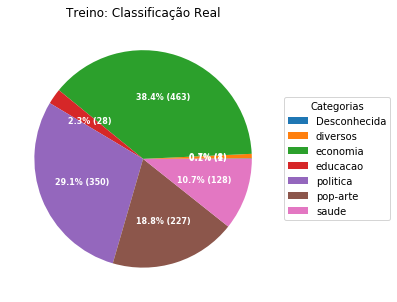

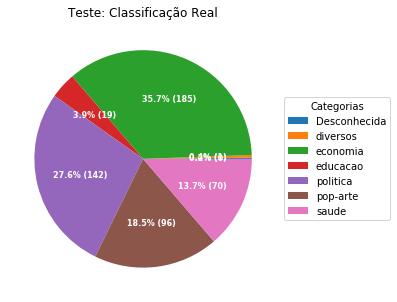

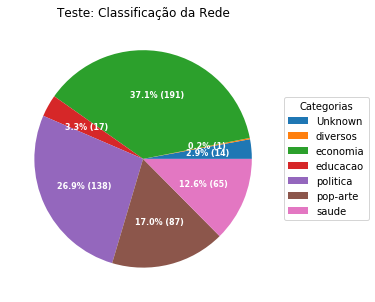

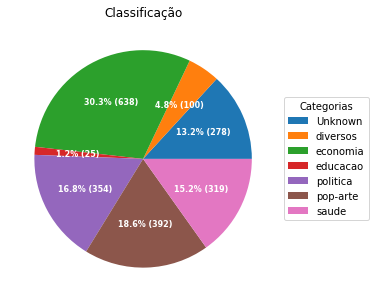

In [364]:
import matplotlib.pyplot as plt

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d})".format(pct, absolute)

def pie(title, legend, data, label):
  fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(aspect="equal"))
  wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))
  ax.legend(wedges, label, title=legend, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
  plt.setp(autotexts, size=8, weight="bold")
  ax.set_title(title)
  plt.show()

counter     = sorted(Counter(np.append(df_cat_treino['cat'], ['Desconhecida'])).items(), key=lambda i: i[0])
dist_treino = pd.DataFrame(counter, columns=['class', 'qtt'])
    
counter     = sorted(Counter(np.append(df_cat_teste['cat'], ['Desconhecida'])).items(), key=lambda i: i[0])
dist_test   = pd.DataFrame(counter, columns=['class', 'qtt'])
    
dist_test_  = classificator.distribution_test_mass
dist_class  = classificator.distribution_unknow_mass

pie("Treino: Classificação Real", "Categorias", dist_treino[['qtt']], dist_test['class'])
pie("Teste: Classificação Real", "Categorias", dist_test[['qtt']], dist_test['class'])
pie("Teste: Classificação da Rede", "Categorias", dist_test_[['qtt']], dist_test_['class'])
pie("Classificação", "Categorias", dist_class[['qtt']], dist_class['class'])

### Gráfico de Barras Comparando Real com Predito na Massa de Teste

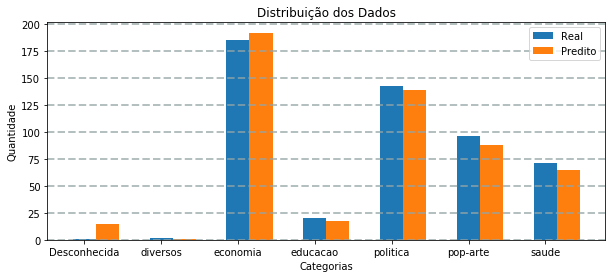

In [367]:
plt.figure(figsize=[10,4])
plt.title("Distribuição dos Dados")
plt.xlabel('Categorias')
plt.ylabel('Quantidade')
plt.xticks(range(7), dist_test['class'])
plt.bar(np.arange(7), dist_test['qtt'], width=0.3, label='Real')
plt.bar(np.arange(7) + 0.3, dist_test_['qtt'], width=0.3, label='Predito')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.legend()
plt.show();

### Matrix de Confusão

In [372]:
y_true = df_cat_teste['cat']
y_pred = classificator.classification

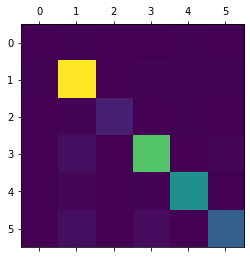

In [373]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
df_matrix = pd.DataFrame(matrix, index=np.unique(y_true), columns=np.unique(y_true))
plt.matshow(df_matrix);

### Heat Map

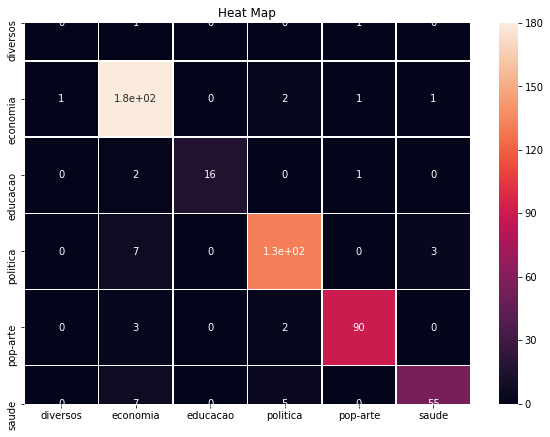

In [374]:
import seaborn as sn
plt.figure(figsize=(10,7))
plt.title("Heat Map")
sn.heatmap(df_matrix, annot=True, linewidths=.5, annot_kws={"size":10})